# Query Expansion

## Installation

In [1]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


## Connecting to the vector database

In [2]:
import chromadb
from helper_utils import load_chroma, word_wrap, project_embeddings
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
from chromadb.config import DEFAULT_TENANT, DEFAULT_DATABASE, Settings

In [3]:
chroma_client = chromadb.PersistentClient(
    path="data/chroma_db/",
    settings=Settings(),
    tenant=DEFAULT_TENANT,
    database=DEFAULT_DATABASE,
)
# Load the existing collection by its name
collection_name = 'microsoft_annual_report_2022'
chroma_collection = chroma_client.get_or_create_collection(name=collection_name)

# Count the number of items in the collection
count = chroma_collection.count()
print(f"Number of items in the collection '{collection_name}': {count}")

Number of items in the collection 'microsoft_annual_report_2022': 349


## The embedding function

In [4]:
# Access the underlying SentenceTransformer model (Defaults)
embedding_function = SentenceTransformerEmbeddingFunction()
model = embedding_function.models
print(model)

/home/vscode/my-envs/03-rag-graph-databases/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/home/vscode/my-envs/03-rag-graph-databases/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


{'all-MiniLM-L6-v2': SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)}


## Helper to print the retrieved documents

In [5]:
def print_results_and_documents(results, retrieved_documents, word_wrap):
    """
    Prints keys and values from the results dictionary and documents with word wrapping.

    Args:
        results (dict): A dictionary where keys are strings and values are either strings or lists.
        retrieved_documents (list): A list of documents to be printed.
        word_wrap (function): A function to apply word wrapping to the documents.

    Returns:
        None
    """
    # Iterate through the dictionary and print each key with its associated value
    for key, value in results.items():
        print(f"{key}:")

        # Check if the value is a list and print its elements
        if isinstance(value, list):
            for i, item in enumerate(value):
                print(f"  Item {i+1}: {item}")
        else:
            # Directly print the value if it's not a list
            print(f"  {value}")

        print()  # Add a newline for better readability

    # Iterate through the list of documents and print each one with word wrapping
    for document in retrieved_documents:
        print(word_wrap(document))
        print('\n')

## Setting up the LLM

In [6]:
from openai import OpenAI
openai_client = OpenAI()

## Visualizing the documents

In [7]:
import umap

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

/home/vscode/my-envs/03-rag-graph-databases/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
100%|██████████| 349/349 [02:48<00:00,  2.07it/s]


## Expansion with generated answers
## Hypothetical answer
https://arxiv.org/abs/2305.03653

In [8]:
def augment_query_generated(query, model="gpt-4o-mini"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Provide an example answer to the given question, that might be found in a document like an annual report. "
        },
        {"role": "user", "content": query}
    ] 

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

In [9]:
original_query = "Was there significant turnover in the executive team?"
hypothetical_answer = augment_query_generated(original_query)

joint_query = f"{original_query} {hypothetical_answer}"
print(word_wrap(joint_query))

Was there significant turnover in the executive team? In the past year,
there was notable stability within the executive team. All key members
of the executive team remained in their positions throughout the entire
fiscal year. There were no new appointments or departures that affected
the core leadership structure of the company. This consistent
leadership continuity has provided stability and a sense of direction
for the organization during a period of growth and transformation.


What they did here is purposly create an LLM hallucination that we can use to enhance the query.

This is used to just create the joint_query

## Find the top 5 results from the vector Database

In [10]:
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings', "distances"])
retrieved_documents = results['documents'][0]

print_results_and_documents(results, retrieved_documents, word_wrap)

ids:
  Item 1: ['69', '338', '333', '343', '324']

distances:
  Item 1: [0.6687174439430237, 0.6809827841280439, 0.6907990556875898, 0.6908798463431958, 0.6939965145855227]

metadatas:
  None

embeddings:
  Item 1: [[-0.018909374251961708, 0.0626523420214653, -0.00501876650378108, 0.040759649127721786, -0.01514834351837635, 0.05255470424890518, -0.0018214141018688679, -0.12902295589447021, 0.0035267428029328585, -0.04559682682156563, -0.03235406056046486, -0.034800149500370026, 0.01580660603940487, -0.018718820065259933, 0.004904366098344326, 0.016312237828969955, 0.04887580871582031, 0.05538848042488098, -0.0807265043258667, -0.07515626400709152, -0.04214925318956375, -0.040162235498428345, -0.003055248176679015, 0.006469323765486479, -0.04461915045976639, -0.06830303370952606, -0.026648597791790962, 0.037733618170022964, -0.004689613822847605, 0.00859820656478405, -0.027555372565984726, -0.03581879287958145, 0.030074937269091606, 0.044950131326913834, -0.07328047603368759, 0.04881776

In [11]:
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


## Visualize the results

(-3.4154350757598877, 8.407795190811157, 4.698742175102234, 10.310700631141662)

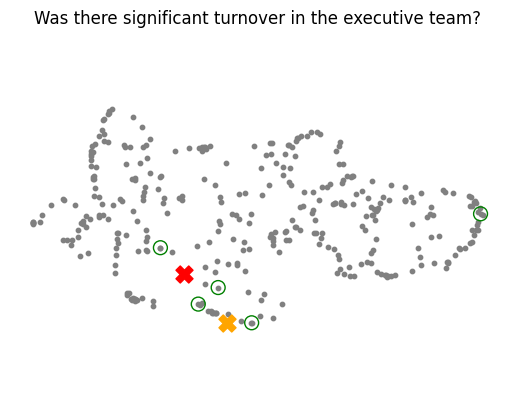

In [12]:
import matplotlib.pyplot as plt

# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

Red is original (hypothetical), Orange is augmented (ChromaDB vectors).

## Expansion with multiple queries

Use an LLM to generate good questions to search through your embeddings.  
The system prompt is more detailed this time.   
You should experiment with differnt prompts.   


In [13]:
def augment_multiple_query(query, model="gpt-4o-mini"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Your users are asking questions about an annual report. "
            "Suggest up to five additional related questions to help them find the information they need, for the provided question. "
            "Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic."
            "Make sure they are complete questions, and that they are related to the original question."
            "Output one question per line. Do not number the questions."
        },
        {"role": "user", "content": query}
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [14]:
original_query = "What were the most important factors that contributed to increases in revenue?"
augmented_queries = augment_multiple_query(original_query)

for query in augmented_queries:
    print(query)

- How did the company's pricing strategy affect revenue growth?
- What impact did new product launches have on revenue?
- Were there any changes in customer demographics that influenced revenue growth?
- How did changes in market demand affect revenue?
- Did acquisitions or partnerships contribute to the increase in revenue?


In [15]:
queries = [original_query] + augmented_queries
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# Deduplicate the retrieved documents (if we get same results multiple times)
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(word_wrap(doc))
        print('')
    print('-'*100)

Query: What were the most important factors that contributed to increases in revenue?

Results:
engineering, gaming, and linkedin. • sales and marketing expenses
increased $ 1. 7 billion or 8 % driven by investments in commercial
sales and linkedin. sales and marketing included a favorable foreign
currency impact of 2 %. • general and administrative expenses increased
$ 793 million or 16 % driven by investments in corporate functions.
operating income increased $ 13. 5 billion or 19 % driven by growth
across each of our segments. current year net income and diluted eps
were positively impacted by the net tax benefit related to the transfer
of intangible properties, which resulted in an increase to net income
and diluted eps of $ 3. 3 billion and $ 0. 44, respectively. prior year
net income and diluted eps were positively impacted by the net tax
benefit related to the india supreme court decision on withholding
taxes, which resulted in an increase to net income and diluted eps of $
620 

In [16]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


In [17]:
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)


100%|██████████| 30/30 [00:14<00:00,  2.01it/s]


(-3.4154350757598877, 8.407795190811157, 4.709564852714538, 10.310185265541076)

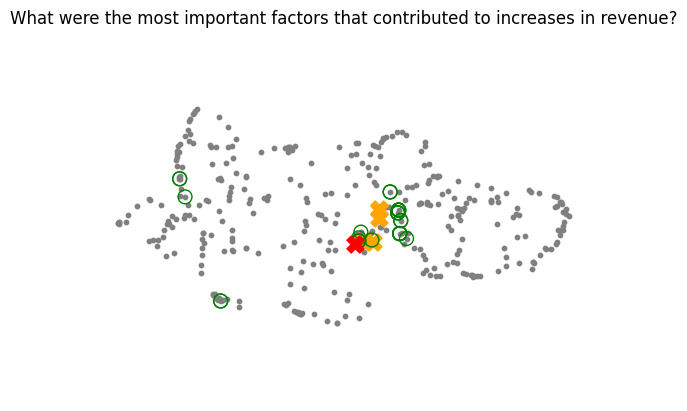

In [18]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

We see we able to hit other parts of the vector we might not have been able to reach with this query expansion technique.   
A single query only hits one point in an embedding space. Multiple queries (questions) hits more areas of the emedding space.   
Gives us a better change of getting beter/more results. 


Food for thought:   
Play around with different queries (i.e. prompts and results).
